# Approximate Dynamic Programming

In [1]:
using Interact
using PGFPlots
using Distributions
include("helpers.jl");

## Function Approximation

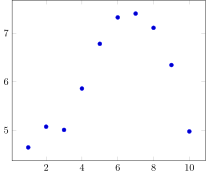

In [2]:
# Generate some random data
srand(0)
s = 1:10
u = 4 - 0.5 * s + 0.35 * s.^2 - 0.03 * s.^3 + rand(length(s))
Plots.Scatter(s, u)

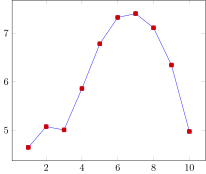

In [3]:
Axis([
        Plots.Linear(s, u),
        Plots.Scatter(s, u)
    ])

In [4]:
function polyfitFunction(X, Y, order)
    λ = polyfit(X, Y, order) # polyfit in helpers.jl
    β(x) = [float(x)^p for p = 0:order]
    (x) -> dot(λ, β(x))
end;

Interact.Options{:SelectionSlider,Int64}(1: "input" = 4 Int64 , "order", 4, "4", Interact.OptionDict(DataStructures.OrderedDict("0"=>0,"1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9…), Dict(0=>"0",4=>"4",7=>"7",9=>"9",2=>"2",3=>"3",5=>"5",8=>"8",6=>"6",1=>"1"…)), Any[], Any[], true, "horizontal")

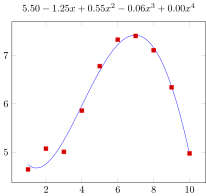

In [5]:
@manipulate for order in 0:9
    title=prettyPolynomial(polyfit(s, u, order))
    Axis([
        Plots.Linear(polyfitFunction(s, u, order), (1,10)),
        Plots.Scatter(s, u),
        ], title=title)
end    

## Cross Entopy Method

In [6]:
# Example true function (has local optima)
V(λ) = 0.5*(exp(-(λ/2).^2) + 2 * exp(-((λ - 10)/2).^2) + 0.75 * exp(-((λ - 5)/2).^2));

In [7]:
# Note: this is designed for univariate functions (easy to generalize, though)
function crossEntropyMethod(f::Function, distribution; steps = 10, populationSize = 20, eliteSize = 5)
    while true
        # draw population of random samples from the distribution
        samples = rand(distribution, populationSize)
        # get the indices of the samples in decreasing order
        index = sortperm(map(f, samples), rev=true)
        # pull off the elite samples
        eliteSamples = samples[index[1:eliteSize]]
        if steps == 0
            return samples, eliteSamples, distribution
        else
            steps = steps - 1
        end
        # update the distribution based on the elite samples
        distribution = fit_mle(Normal, eliteSamples)
    end
end;

Interact.Options{:SelectionSlider,Int64}(5: "input-2" = 2 Int64 , "steps", 2, "2", Interact.OptionDict(DataStructures.OrderedDict("0"=>0,"1"=>1,"2"=>2,"3"=>3,"4"=>4), Dict(0=>"0",4=>"4",2=>"2",3=>"3",1=>"1")), Any[], Any[], true, "horizontal")

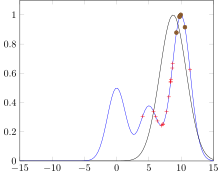

In [8]:
initialDistribution = Normal(0, 1)
domain = (-15,15)
@manipulate for steps = 0:4
    srand(0)
    (samples, eliteSamples, distribution) = crossEntropyMethod(λ->V(λ), Normal(0., 10.), steps = steps)
    densityScale = 1/pdf(distribution, distribution.μ)
    density = λ->densityScale*pdf(distribution, λ)
    Axis([
        Plots.Linear(V, domain),
        Plots.Scatter(samples, map(V, samples), mark="+"),
        Plots.Scatter(eliteSamples, map(V, eliteSamples)),
        Plots.Linear(density, domain)
        ], xmin=domain[1], xmax=domain[2], ymin=0
    )
end

# Function Approximation Value Iteration

In [1]:
using ContinuumWorld
using POMDPs
using Interact
value = Interact.value
using GridInterpolations
using Plots
pyplot() # or you can use e.g. gr() or plotly()

Plots.PyPlotBackend()


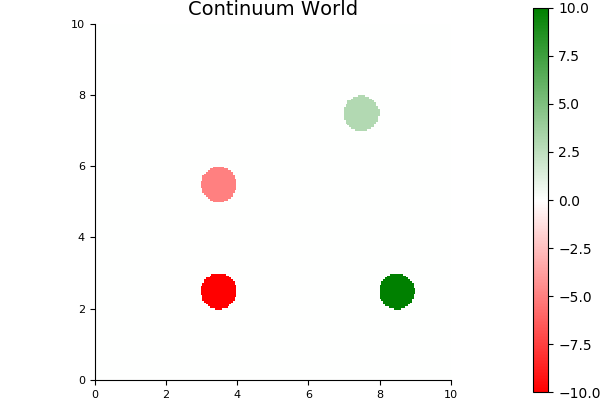

In [2]:
w = CWorld()

dummy_s = Vec2(0.0, 0.0)
dummy_a = Vec2(0.0, 0.0)
plot(CWorldVis(w, f=sp->reward(w,dummy_s,dummy_a,sp)))

In [7]:
nx = 30
ny = 30
grid = RectangleGrid(linspace(w.xlim..., nx), linspace(w.ylim..., ny))

sol = CWorldSolver(max_iters=50, m=50, grid=grid)

@time policy = solve(sol, w);

finished iteration 50
extracting policy...     done.
  3.879835 seconds (38.70 M allocations: 2.376 GiB, 15.46% gc time)


Interact.Options{:SelectionSlider,Any}(9: "input-3" = 25 Any , "i", 25, "25", 25, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(2, "2"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(46, "46"),Pair{Any,Any}(25, "25"),Pair{Any,Any}(42, "42"),Pair{Any,Any}(29, "29"),Pair{Any,Any}(8, "8"),Pair{Any,Any}(20, "20"),Pair{Any,Any}(14, "14")…)), Any[], Any[], true, "horizontal")


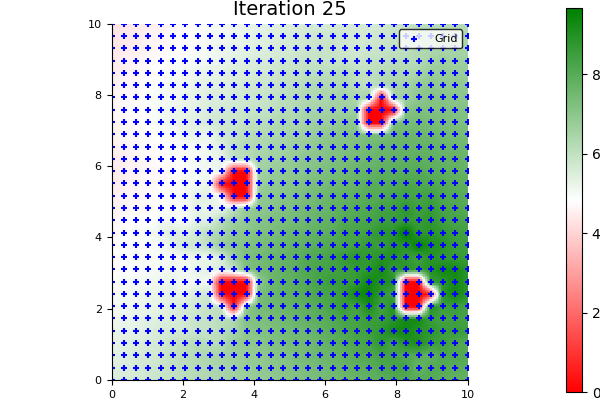

In [10]:
@manipulate for i in 1:length(sol.value_hist)
    v = sol.value_hist[i]
    plot(CWorldVis(w, f=s->evaluate(v, s), g=sol.grid, title="Iteration $i"))
end


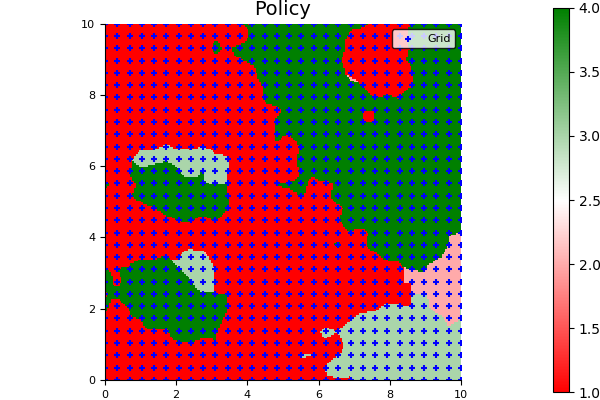

In [9]:
plot(CWorldVis(w, f=s->action_ind(policy, s), g=sol.grid, title="Policy"))